Here we should make sure that Transformer model is Ok to be used as a denoising autoencoder

In [1]:
import sys; sys.path += ['..', '../src']

In [2]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.de.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.de.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

train_src = [s.split()[:max_len-2] for s in train_src]
train_trg = [s.split()[:max_len-2] for s in train_trg]
val_src = [s.split()[:max_len-2] for s in val_src]
val_trg = [s.split()[:max_len-2] for s in val_trg]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.de'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [3]:
from src.transformer.models import Transformer

model = Transformer(
    len(vocab_src),
    len(vocab_trg),
    max_len,
    n_layers=6,
    n_head=8,
    d_word_vec=512,
    d_model=512,
    d_inner_hid=2048,
    d_k=64,
    d_v=64)

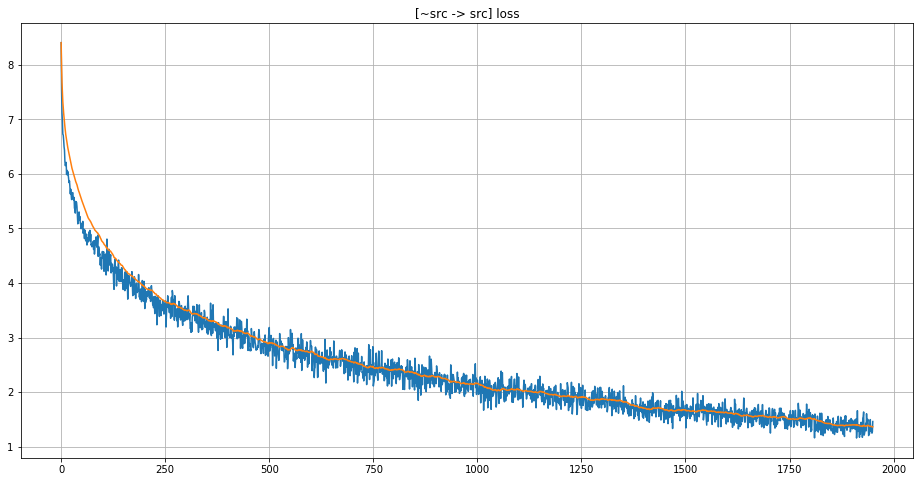

KeyboardInterrupt: 

In [4]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
tqdm.monitor_interval = 0

from src.utils.umt_batcher import UMTBatcher
import src.transformer.constants as constants


use_cuda = torch.cuda.is_available()

def get_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)


optimizer = Adam(model.get_trainable_parameters(), lr=1e-4, betas=(0.9, 0.98))
criterion = get_criterion(len(vocab_src))

seq_noise_options = {'shuffle_window': 3, 'dropout_prob': 0.1}

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab_src, vocab_trg,
                           batch_size=64, shuffle=True, seq_noise_options=seq_noise_options)
val_data = UMTBatcher(val_src_idx, val_trg_idx, vocab_src,
                      vocab_trg, batch_size=32, shuffle=True)

if use_cuda:
    model.cuda()
    criterion.cuda()

model.train()
loss_history = []
val_loss_history = []
val_loss_iters = []
num_iters_done = 0
max_num_epochs = 10

for i in range(max_num_epochs):
    for batch in tqdm(training_data, leave=False):
        src_noised, trg_noised, src, trg = batch
        optimizer.zero_grad()
        src_preds = model(src_noised, src, use_src_embs_in_decoder=True)
        loss = criterion(src_preds, src[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()

        loss_history.append(loss.data[0])

        if num_iters_done % 25 == 0:
            clear_output(True)
            plt.figure(figsize=[16,8])
            plt.title("[~src -> src] loss")
            plt.plot(loss_history)
            plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=50).mean())
            plt.plot(val_loss_iters, val_loss_history)
            plt.grid()
            plt.show()
            
        if False and num_iters_done % 100 == 0:
            val_losses = []
            for val_batch in val_data:
                val_src_noised, val_trg_noised, val_src, val_trg = val_batch
                val_src_preds = model(val_src_noised, val_src, use_src_embs_in_decoder=True)
                val_loss = criterion(val_src_preds, val_src[:, 1:].contiguous().view(-1))
                val_losses.append(val_loss.data[0])

            val_loss_history.append(np.mean(val_losses))
            val_loss_iters.append(num_iters_done)
            
        num_iters_done += 1

In [5]:
noised = [vocab_src.detokenize(t) for t in src_noised.data]
normal = [vocab_src.detokenize(t) for t in src.data]

noised = [' '.join(t.split()[1:-1]) for t in noised]
normal = [' '.join(t.split()[1:-1]) for t in normal]

for i in range(10):
    print('Noised:', noised[10+i])
    print('Normal:', normal[10+i])
    print()

Noised: man A look up@@ and woman on ward a block .
Normal: A man and woman look up@@ ward on a city block .

Noised: e@@ scape ver@@ Con@@ wearing artist stru@@ high tops se as one looks . on
Normal: An e@@ scape artist wearing Con@@ ver@@ se high tops stru@@ ggles on one foot as a crowd looks on .

Noised: woman A standing in a doorway dark into waiting building , the be .
Normal: A woman standing in a dark doorway , waiting to be let into the building .

Noised: short in man A shorts on a is posing rock large .
Normal: A man in short shorts is posing on a large rock .

Noised: a of ette ting parachu@@ figure sunset at .
Normal: A silhou@@ ette of a figure parachu@@ ting at sunset .

Noised: blue A shirt the mound , on gr@@ his practices i@@ p before pitch the throwing .
Normal: A pitcher in a blue shirt , on the mound , practices his gr@@ i@@ p before throwing the pitch .

Noised: in man young A gray a flower his and head a on pose stri@@ after a . meal
Normal: A young man in a gray

In [6]:
import numpy as np
from src.utils.bleu import compute_bleu_for_sents

model.eval()

val_data = UMTBatcher(val_src_idx, val_trg_idx, vocab_src,
                      vocab_trg, batch_size=32, shuffle=True)

all_reconstructions = []
all_targets = []

for test_batch in val_data:
    reconstructions = model.translate_batch(test_batch[0], max_len=max_len,
                                            beam_size=4, use_src_embs_in_decoder=True)
    
    reconstructions = [vocab_src.remove_bpe(vocab_src.detokenize(t)) for t in reconstructions]
    targets = [vocab_src.remove_bpe(vocab_src.detokenize(s)) for s in test_batch[2].data]

    reconstructions = [' '.join(t.split()[:-1]) for t in reconstructions]
    targets = [' '.join(t.split()[1:-1]) for t in targets]
    
    all_reconstructions += reconstructions
    all_targets += targets
    
print('BLEU:', compute_bleu_for_sents(reconstructions, targets))

 36%|███▌      | 18/50 [00:00<00:01, 18.34it/s]

BLEU: 0.48609032348029985


In [7]:
for i in range(10):
    print('Reconstruction:', all_reconstructions[i])
    print('Target        :', all_targets[i])

Reconstruction: A boy in yellow and yellow dress is pushing .
Target        : A boy in green and yellow dress is learning boxing .
Reconstruction: A man is pushing chairs on a street .
Target        : A man is pushing chairs on a busy street .
Reconstruction: A group of people with white shirts walking up on the sidewalk talking .
Target        : Two people with white shirts walking up the sidewalk talking on their phones .
Reconstruction: A men on a parade with a parade through a crowded street with people .
Target        : Several men standing on a parade float traveling through a street crowded with people .
Reconstruction: A man and woman are walking up a stone staircase , looking at a video camera .
Target        : A man and woman are walking up a stone staircase , looking at a video camera .
Reconstruction: A man holds while leaning against an infant .
Target        : A man holds an infant while leaning against a building .
Reconstruction: A Asian woman in a very poistal uniform 